In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import sys
import tensorflow.compat.v1 as tf

In [2]:
## 1. Compare reconstruction

PLOT=True

## 1. load training data -- 20 

FILENAME = './DATA_FINAL/ks_train_n_20.npz'

data=np.load(FILENAME)['data']
mean = np.load(FILENAME)['mean']
std = np.load(FILENAME)['std']

# using only the normalized data
data_raw = data # visualize the normalized data, how it works

N_TRAIN = int(data_raw[:,0].shape[0]/25600)

## 2. load testing data
FILENAME = './DATA_FINAL/ks_test_n_59.npz'

data_te=np.load(FILENAME)['data']
mean_te = np.load(FILENAME)['mean']
std_te = np.load(FILENAME)['std']

# 1. unnormalized
data_te_un = data_te*std_te + mean_te

# 2. normalize with training range
data_te_n = (data_te_un - mean)/std

N_TEST = int(data_te_n[:,0].shape[0]/25600)

CASE_PATH = './ks_0'


def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

MODEL_LIST = ['change_mp_swish_train_20/1_less/MLP_1',
              'change_mp_swish_train_20/1_less/MLP_2',
              'change_mp_swish_train_20/1_less/MLP_3',
              'change_mp_swish_train_20/1_less/MLP_4',
              'change_mp_swish_train_20/1_less/NIF_1',
              'change_mp_swish_train_20/1_less/NIF_2',
              'change_mp_swish_train_20/1_less/NIF_3',
              'change_mp_swish_train_20/1_less/NIF_4',
              'change_mp_swish_train_20/1.5_lm/MLP_1',
              'change_mp_swish_train_20/1.5_lm/MLP_2',
              'change_mp_swish_train_20/1.5_lm/MLP_3',
              'change_mp_swish_train_20/1.5_lm/MLP_4',
              'change_mp_swish_train_20/1.5_lm/NIF_1',
              'change_mp_swish_train_20/1.5_lm/NIF_2',
              'change_mp_swish_train_20/1.5_lm/NIF_3',
              'change_mp_swish_train_20/1.5_lm/NIF_4',
              'train_20_swish/swish/MLP_1',
              'train_20_swish/swish/MLP_2',
              'train_20_swish/swish/MLP_3',
              'train_20_swish/swish/MLP_4',
              'train_20_swish/swish/NIF_1',
              'train_20_swish/swish/NIF_2',
              'train_20_swish/swish/NIF_3',
              'train_20_swish/swish/NIF_4',
              'change_mp_swish_train_20/2.5_mh/MLP_1',
              'change_mp_swish_train_20/2.5_mh/MLP_2',
              'change_mp_swish_train_20/2.5_mh/MLP_3',
              'change_mp_swish_train_20/2.5_mh/MLP_4',
              'change_mp_swish_train_20/2.5_mh/NIF_1',
              'change_mp_swish_train_20/2.5_mh/NIF_2',
              'change_mp_swish_train_20/2.5_mh/NIF_3',
              'change_mp_swish_train_20/2.5_mh/NIF_4',
              'change_mp_swish_train_20/3_high/MLP_1',
              'change_mp_swish_train_20/3_high/MLP_2',
              'change_mp_swish_train_20/3_high/MLP_3',
              'change_mp_swish_train_20/3_high/MLP_4',
              'change_mp_swish_train_20/3_high/NIF_1',
              'change_mp_swish_train_20/3_high/NIF_2',
              'change_mp_swish_train_20/3_high/NIF_3',
              'change_mp_swish_train_20/3_high/NIF_4',
            ]



def compute_error_across_all_nu(MODEL):

    model_dir = CASE_PATH + '/' + MODEL + '/saved_model_ckpt_40000'

    sess = tf.Session(graph=tf.Graph())
    MODEL_LOADED=tf.saved_model.loader.load(sess, ["serve"], model_dir)
    graph = sess.graph


    # load input tensors
    INPUT_T = graph.get_tensor_by_name('input_T:0')
    INPUT_NU = graph.get_tensor_by_name('input_NU:0')
    INPUT_X = graph.get_tensor_by_name('input_X:0')

    # ouput tensor
    OUTPUT_U = graph.get_tensor_by_name('output_u:0')

    
    ## evaluate training error
    PRED_U_LIST = []
    TRUE_U_LIST = []
    NU_LIST = []
    for j in range(N_TRAIN):
        # print(j)
        # evaluate on the training data
        input_arr_nu = data_raw[25600*j:25600*(j+1),0].reshape(-1,1)
        # print(np.std(input_arr_nu))
        input_arr_t = data_raw[25600*j:25600*(j+1),2].reshape(-1,1)
        input_arr_x = data_raw[25600*j:25600*(j+1),1].reshape(-1,1)
        output_arr_u = sess.run(OUTPUT_U, feed_dict={INPUT_T:input_arr_t, INPUT_NU: input_arr_nu, INPUT_X:input_arr_x })
        true_arr_u = data_raw[25600*j:25600*(j+1),3].reshape(-1,1)
        
        PRED_U_LIST.append(output_arr_u)
        TRUE_U_LIST.append(true_arr_u)
        NU_LIST.append(input_arr_nu[0])

        # un-normalized target
        output_arr_u = output_arr_u*std[-1] + mean[-1]
        true_arr_u = true_arr_u*std[-1] + mean[-1]
    
        ## plot the contour
        tt = input_arr_t.reshape(256,100)*std[2] + mean[2]
        xx = input_arr_x.reshape(256,100)*std[1] + mean[1]
        
    l2_err_list = []
    for i in range(len(PRED_U_LIST)):
        uu   = PRED_U_LIST[i].reshape(256,100)
        uu_t = TRUE_U_LIST[i].reshape(256,100)
        # l2_err = np.linalg.norm(uu-uu_t) / 25600
        l2_err = rmse(uu,uu_t)
        l2_err_list.append(l2_err)

    l2_err_array_tr = np.array(l2_err_list)
    mean_err_tr = np.mean(l2_err_array_tr)
    std_err_tr = np.std(l2_err_array_tr)
    nu_tr = np.array(NU_LIST)

    ## evaluate the testing error
    PRED_U_LIST = []
    TRUE_U_LIST = []
    NU_LIST = []
    for j in range(N_TEST):
        # print(j)
        # evaluate on the training data
        input_arr_nu = data_te_n[25600*j:25600*(j+1),0].reshape(-1,1)
        # print(np.std(input_arr_nu))
        input_arr_t = data_te_n[25600*j:25600*(j+1),2].reshape(-1,1)
        input_arr_x = data_te_n[25600*j:25600*(j+1),1].reshape(-1,1)
        output_arr_u = sess.run(OUTPUT_U, feed_dict={INPUT_T:input_arr_t, INPUT_NU: input_arr_nu, INPUT_X:input_arr_x })
        true_arr_u = data_te_n[25600*j:25600*(j+1),3].reshape(-1,1)
        
        
        # un-normalized target
        output_arr_u = output_arr_u*std[-1] + mean[-1]
        true_arr_u = true_arr_u*std[-1] + mean[-1]
        
        PRED_U_LIST.append(output_arr_u)
        TRUE_U_LIST.append(true_arr_u)
        NU_LIST.append(input_arr_nu[0])

    l2_err_list = []
    for i in range(len(PRED_U_LIST)):
        uu   = PRED_U_LIST[i].reshape(256,100)
        uu_t = TRUE_U_LIST[i].reshape(256,100)
        l2_err = rmse(uu,uu_t)
        # l2_err = np.linalg.norm(uu-uu_t) / 25600
        l2_err_list.append(l2_err)
        print('NU =', NU_LIST[i][0]*std[0]+mean[0])

    l2_err_array_te = np.array(l2_err_list)
    mean_err_te = np.mean(l2_err_array_te)
    std_err_te = np.std(l2_err_array_te)
    nu_te = np.array(NU_LIST)
    
    return mean_err_tr, std_err_tr, nu_tr, l2_err_array_tr, mean_err_te, std_err_te, nu_te, l2_err_array_te

# plt.figure(figsize=(8,8))

In [3]:
if PLOT == False:
    l2_err_array_tr_list = []
    l2_err_array_te_list = []
    for MODEL in MODEL_LIST:
        print('')
        print('==================')
        print('model = ', MODEL)
        print('==================')

        mean_err_tr, std_err_tr, nu_tr, l2_err_array_tr, mean_err_te, std_err_te, nu_te, l2_err_array_te = \
                                                  compute_error_across_all_nu(MODEL)

        print('MEAN ERR (TRAIN) = ', mean_err_tr)
        print('STD ERR (TRAIN) = ', std_err_tr)
        print('MEAN ERR (TEST) = ', mean_err_te)
        print('STD ERR (TEST) = ', std_err_te)

        l2_err_array_tr_list.append(l2_err_array_tr)
        l2_err_array_te_list.append(l2_err_array_te)
        # plt.plot(l2_err_array_tr,label=MODEL + ' (TR)')
        # plt.plot(l2_err_array_te,label=MODEL + ' (TE)')

    ## compute error stat

    import seaborn as sns

    mlp_less_tr = np.array(l2_err_array_tr_list[0:4])
    mlp_less_te = np.array(l2_err_array_te_list[0:4])
    nif_less_tr = np.array(l2_err_array_tr_list[4:8])
    nif_less_te = np.array(l2_err_array_te_list[4:8])

    mlp_lm_tr = np.array(l2_err_array_tr_list[8:12])
    mlp_lm_te = np.array(l2_err_array_te_list[8:12])
    nif_lm_tr = np.array(l2_err_array_tr_list[12:16])
    nif_lm_te = np.array(l2_err_array_te_list[12:16])

    mlp_mid_tr = np.array(l2_err_array_tr_list[16:20])
    mlp_mid_te = np.array(l2_err_array_te_list[16:20])
    nif_mid_tr = np.array(l2_err_array_tr_list[20:24])
    nif_mid_te = np.array(l2_err_array_te_list[20:24])

    mlp_mh_tr = np.array(l2_err_array_tr_list[24:28])
    mlp_mh_te = np.array(l2_err_array_te_list[24:28])
    nif_mh_tr = np.array(l2_err_array_tr_list[28:32])
    nif_mh_te = np.array(l2_err_array_te_list[28:32])

    mlp_more_tr = np.array(l2_err_array_tr_list[32:36])
    mlp_more_te = np.array(l2_err_array_te_list[32:36])
    nif_more_tr = np.array(l2_err_array_tr_list[36:40])
    nif_more_te = np.array(l2_err_array_te_list[36:40])

    #############

    mlp_less_tr_mean = mlp_less_tr.mean(axis=0)
    mlp_less_te_mean = mlp_less_te.mean(axis=0)
    nif_less_tr_mean = nif_less_tr.mean(axis=0)
    nif_less_te_mean = nif_less_te.mean(axis=0)

    mlp_lm_tr_mean = mlp_lm_tr.mean(axis=0)
    mlp_lm_te_mean = mlp_lm_te.mean(axis=0)
    nif_lm_tr_mean = nif_lm_tr.mean(axis=0)
    nif_lm_te_mean = nif_lm_te.mean(axis=0)

    mlp_mid_tr_mean = mlp_mid_tr.mean(axis=0)
    mlp_mid_te_mean = mlp_mid_te.mean(axis=0)
    nif_mid_tr_mean = nif_mid_tr.mean(axis=0)
    nif_mid_te_mean = nif_mid_te.mean(axis=0)

    mlp_mh_tr_mean = mlp_mh_tr.mean(axis=0)
    mlp_mh_te_mean = mlp_mh_te.mean(axis=0)
    nif_mh_tr_mean = nif_mh_tr.mean(axis=0)
    nif_mh_te_mean = nif_mh_te.mean(axis=0)

    mlp_more_tr_mean = mlp_more_tr.mean(axis=0)
    mlp_more_te_mean = mlp_more_te.mean(axis=0)
    nif_more_tr_mean = nif_more_tr.mean(axis=0)
    nif_more_te_mean = nif_more_te.mean(axis=0)
    
    ## scaling the nu's
    nu_tr_ = mean[0] + std[0]*nu_tr
    nu_te_ = mean_te[0] + std_te[0]*nu_te

    ## save the data

    np.savez('./tmp_result/result_change_mp.npz',
             # less
             mlp_less_tr_mean=mlp_less_tr_mean,
             mlp_less_te_mean=mlp_less_te_mean,
             nif_less_tr_mean=nif_less_tr_mean,
             nif_less_te_mean=nif_less_te_mean,
             # less-mid
             mlp_lm_tr_mean=mlp_lm_tr_mean,
             mlp_lm_te_mean=mlp_lm_te_mean,
             nif_lm_tr_mean=nif_lm_tr_mean,
             nif_lm_te_mean=nif_lm_te_mean,
             # mid
             mlp_mid_tr_mean=mlp_mid_tr_mean,
             mlp_mid_te_mean=mlp_mid_te_mean,
             nif_mid_tr_mean=nif_mid_tr_mean,
             nif_mid_te_mean=nif_mid_te_mean,
             # mid to high
             mlp_mh_tr_mean=mlp_mh_tr_mean,
             mlp_mh_te_mean=mlp_mh_te_mean,
             nif_mh_tr_mean=nif_mh_tr_mean,
             nif_mh_te_mean=nif_mh_te_mean,
             # more
             mlp_more_tr_mean=mlp_more_tr_mean,
             mlp_more_te_mean=mlp_more_te_mean,
             nif_more_tr_mean=nif_more_tr_mean,
             nif_more_te_mean=nif_more_te_mean,
             nu_tr_=nu_tr_,
             nu_te_=nu_te_
            )

TRAINING ERROR

MLP-less 0.0549658823703331
NIF-less 0.03267007144319754

MLP-lm 0.042977965639573
NIF-lm 0.03223092953739821

MLP-mid 0.02286764032938167
NIF-mid 0.019343961209764206

MLP-mh 0.021020257002724054
NIF-mh 0.015092025984778764

MLP-high 1.0059150809745294
NIF-high 0.5706659341042406

TESTING ERROR

MLP-less 1.3334797721056337
NIF-less 0.652702282104064

MLP-lm 1.2226135661828448
NIF-lm 0.6616555403847485

MLP-mid 1.0910782615157195
NIF-mid 0.6457560406434121

MLP-mh 1.0509668361222557
NIF-mh 0.5235969384322187

MLP-high 1.0059150809745294
NIF-high 0.5706659341042406


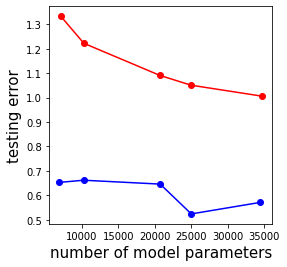

In [5]:
if PLOT:
    ddd = np.load('./tmp_result/result_change_mp.npz')

    mlp_less_tr_mean=ddd['mlp_less_tr_mean']
    mlp_less_te_mean=ddd['mlp_less_te_mean']
    nif_less_tr_mean=ddd['nif_less_tr_mean']
    nif_less_te_mean=ddd['nif_less_te_mean']
    
    mlp_mid_tr_mean=ddd['mlp_mid_tr_mean']
    mlp_mid_te_mean=ddd['mlp_mid_te_mean']
    nif_mid_tr_mean=ddd['nif_mid_tr_mean']
    nif_mid_te_mean=ddd['nif_mid_te_mean']
    
    mlp_lm_tr_mean=ddd['mlp_lm_tr_mean']
    mlp_lm_te_mean=ddd['mlp_lm_te_mean']
    nif_lm_tr_mean=ddd['nif_lm_tr_mean']
    nif_lm_te_mean=ddd['nif_lm_te_mean']
    
    mlp_mh_tr_mean=ddd['mlp_mh_tr_mean']
    mlp_mh_te_mean=ddd['mlp_mh_te_mean']
    nif_mh_tr_mean=ddd['nif_mh_tr_mean']
    nif_mh_te_mean=ddd['nif_mh_te_mean']
    
    mlp_more_tr_mean=ddd['mlp_more_tr_mean']
    mlp_more_te_mean=ddd['mlp_more_te_mean']
    nif_more_tr_mean=ddd['nif_more_tr_mean']
    nif_more_te_mean=ddd['nif_more_te_mean']

    nu_tr_=ddd['nu_tr_']
    nu_te_=ddd['nu_te_']

    id_nu_tr=np.argsort(nu_tr_,axis=0)
    id_nu_te=np.argsort(nu_te_,axis=0)

    ## define the plotting function
    def plot_train_test_rmse(mlp_tr,mlp_te,nif_tr,nif_te, title,fig_filename):

        fig,axs=plt.subplots(1,2,figsize=(10,4))
        axs[0].plot(nu_tr_.ravel()[id_nu_tr], mlp_tr[id_nu_tr],'ro-',label='MLP')
        axs[0].plot(nu_tr_.ravel()[id_nu_tr], nif_tr[id_nu_tr],'ko-',label='NIF')
        axs[0].legend(loc='best',fontsize=15)
        axs[0].set_yscale('log')
        axs[0].set_ylabel('rmse',fontsize=30)
        axs[0].set_title('train',fontsize=25)
        axs[0].set_xlim([0.195,0.285])
        axs[0].set_xlabel(r'$\mu$',fontsize=30)


        axs[1].plot(nu_te_.ravel()[id_nu_te], mlp_te[id_nu_te],'ro-',label='MLP')
        axs[1].plot(nu_te_.ravel()[id_nu_te], nif_te[id_nu_te],'ko-',label='NIF')
        axs[1].set_yscale('log')
        axs[1].set_title('test',fontsize=25)
        # axs[1].set_ylabel('testing rmse',fontsize=25)
        axs[1].set_xlim([0.195,0.285])
        axs[1].set_xlabel(r'$\mu$',fontsize=30)

        axs[0].tick_params(axis='both', labelsize=25)
        axs[1].tick_params(axis='both', labelsize=25)

        fig.tight_layout()
        fig.suptitle(title,fontsize=30,x=0.25,y=1.05)
        # fig.subplots_adjust(bottom=0.5, top=1.05)
        plt.savefig('./paper-pngs/appendix_{}.png'.format(fig_filename),bbox_inches='tight')
        plt.close()
        # plt.savefig('./pngs/ks_0_change_mp_less.png',bbox_inches='tight')

    ## 1. draw less

    mlp_tr=mlp_less_tr_mean
    mlp_te=mlp_less_te_mean
    nif_tr=nif_less_tr_mean
    nif_te=nif_less_te_mean

    plot_train_test_rmse(mlp_tr,mlp_te,nif_tr,nif_te, '(1) NIF (6935), MLP (7135)','ks_0_change_mp_less')

    ## 2. draw less-mid

    mlp_tr=mlp_lm_tr_mean
    mlp_te=mlp_lm_te_mean
    nif_tr=nif_lm_tr_mean
    nif_te=nif_lm_te_mean

    plot_train_test_rmse(mlp_tr,mlp_te,nif_tr,nif_te,'(2) NIF (10254), MLP (10291)', 'ks_0_change_mp_lm')

    ## 3 draw mid

    mlp_tr=mlp_mid_tr_mean
    mlp_te=mlp_mid_te_mean
    nif_tr=nif_mid_tr_mean
    nif_te=nif_mid_te_mean

    plot_train_test_rmse(mlp_tr,mlp_te,nif_tr,nif_te,'(3) NIF (20741), MLP (20701)', 'ks_0_change_mp_middle')

    ## 4. draw mid-high

    mlp_tr=mlp_mh_tr_mean
    mlp_te=mlp_mh_te_mean
    nif_tr=nif_mh_tr_mean
    nif_te=nif_mh_te_mean

    plot_train_test_rmse(mlp_tr,mlp_te,nif_tr,nif_te, '(4) NIF (24996), MLP (24971)','ks_0_change_mp_mh')

    ## 5. draw hihg amount of model parameters

    mlp_tr=mlp_more_tr_mean
    mlp_te=mlp_more_te_mean
    nif_tr=nif_more_tr_mean
    nif_te=nif_more_te_mean

    plot_train_test_rmse(mlp_tr,mlp_te,nif_tr,nif_te, '(5) NIF (34415), MLP (34711)','ks_0_change_mp_high')



    ## Plot error curve

    nmp_mlp_less = 7135
    nmp_nif_less = 6935

    nmp_mlp_lm = 10291
    nmp_nif_lm = 10254

    nmp_mlp_mid = 20701
    nmp_nif_mid = 20741

    nmp_mlp_mh = 24971
    nmp_nif_mh = 24996

    nmp_mlp_more = 34711
    nmp_nif_more = 34415

    mp_mlp = []
    te_err_mlp = []

    mp_nif = []
    te_err_nif = []

    print('TRAINING ERROR')
    print('')
    print('MLP-less',np.mean(mlp_less_tr_mean))
    print('NIF-less',np.mean(nif_less_tr_mean))

    print('')
    print('MLP-lm',np.mean(mlp_lm_tr_mean))
    print('NIF-lm',np.mean(nif_lm_tr_mean))

    print('')
    print('MLP-mid',np.mean(mlp_mid_tr_mean))
    print('NIF-mid',np.mean(nif_mid_tr_mean))

    print('')
    print('MLP-mh',np.mean(mlp_mh_tr_mean))
    print('NIF-mh',np.mean(nif_mh_tr_mean))

    print('')
    print('MLP-high',np.mean(mlp_more_te_mean))
    print('NIF-high',np.mean(nif_more_te_mean))



    print('')
    print('TESTING ERROR')
    print('')
    print('MLP-less',np.mean(mlp_less_te_mean))
    print('NIF-less',np.mean(nif_less_te_mean))

    print('')
    print('MLP-lm',np.mean(mlp_lm_te_mean))
    print('NIF-lm',np.mean(nif_lm_te_mean))

    print('')
    print('MLP-mid',np.mean(mlp_mid_te_mean))
    print('NIF-mid',np.mean(nif_mid_te_mean))

    print('')
    print('MLP-mh',np.mean(mlp_mh_te_mean))
    print('NIF-mh',np.mean(nif_mh_te_mean))

    print('')
    print('MLP-high',np.mean(mlp_more_te_mean))
    print('NIF-high',np.mean(nif_more_te_mean))


    ##############

    mp_mlp.append(nmp_mlp_less)
    te_err_mlp.append(np.mean(mlp_less_te_mean))
    mp_nif.append(nmp_nif_less)
    te_err_nif.append(np.mean(nif_less_te_mean))

    mp_mlp.append(nmp_mlp_lm)
    te_err_mlp.append(np.mean(mlp_lm_te_mean))
    mp_nif.append(nmp_nif_lm)
    te_err_nif.append(np.mean(nif_lm_te_mean))

    mp_mlp.append(nmp_mlp_mid)
    te_err_mlp.append(np.mean(mlp_mid_te_mean))
    mp_nif.append(nmp_nif_mid)
    te_err_nif.append(np.mean(nif_mid_te_mean))

    mp_mlp.append(nmp_mlp_mh)
    te_err_mlp.append(np.mean(mlp_mh_te_mean))
    mp_nif.append(nmp_nif_mh)
    te_err_nif.append(np.mean(nif_mh_te_mean))

    mp_mlp.append(nmp_mlp_more)
    te_err_mlp.append(np.mean(mlp_more_te_mean))
    mp_nif.append(nmp_nif_more)
    te_err_nif.append(np.mean(nif_more_te_mean))


    ## save the data... 

    np.savez('./tmp_result/ks_0_change_mp_'+str(N_TRAIN)+'.npz',mp_mlp=mp_mlp,
            te_err_mlp=te_err_mlp, mp_nif=mp_nif,te_err_nif=te_err_nif)

    ## plot figure 9 (right)

    tmp_data = np.load('./tmp_result/ks_0_change_mp_'+str(N_TRAIN)+'.npz')
    mp_mlp = tmp_data['mp_mlp']
    te_err_mlp = tmp_data['te_err_mlp']
    mp_nif = tmp_data['mp_nif']
    te_err_nif = tmp_data['te_err_nif']

    plt.figure(figsize=(4,4))
    plt.plot(mp_mlp, te_err_mlp,'ro-',label='MLP')
    plt.plot(mp_nif, te_err_nif,'bo-',label='NIF')
    # plt.legend(loc='best')

    # plt.yscale('log')
    plt.xlabel('number of model parameters',fontsize=15)
    plt.ylabel('testing error',fontsize=15)
    plt.savefig('./paper-pngs/ks_0_change_mp.png',bbox_inches='tight')